# Test of GraphSAGE
- the version of the 20 repeat times
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:3


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [5]:
datasets = ['repeat_train', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/repeat_train.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [6]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(16)

- Turn the print message to a log file

In [7]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1010_15:50_GraphSAGE_transR_50.log


### Model

In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'pool')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [10]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [11]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [12]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [13]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

- Check if model really load the model_dict

In [14]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

In [16]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-4.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['repeat_train'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        
#     scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 15:52:18# labels of 5000: tensor([ 12, 112,  53,  33, 110, 110,  18, 158,  57,  92,  53, 112, 144,  42,
          4,  92, 111], device='cuda:3') torch.Size([17])
10/10/2023, 15:52:18# predicted of 5000: tensor([30, 83, 36, 83, 30, 30, 30, 83, 30, 83, 83, 83, 83, 36, 83, 30, 30],
       device='cuda:3') torch.Size([17])
10/10/2023, 15:53:14# labels of 10000: tensor([150, 124, 104,  33, 152,  74,  97,  60, 150, 112, 152, 109,  18,  44,
        162, 151], device='cuda:3') torch.Size([16])
10/10/2023, 15:53:14# predicted of 10000: tensor([ 97, 157,  12, 125,   2,  57, 125,  53, 150, 124, 150, 157, 150,  56,
          2,  97], device='cuda:3') torch.Size([16])
10/10/2023, 15:54:11# labels of 15000: tensor([152,  49, 121,  87,  30, 125, 144,  87,  92, 104,  34,   9,  47, 124,
        142,  81], device='cuda:3') torch.Size([16])
10/10/2023, 15:54:11# predicted of 15000: tensor([ 34, 119,  34,  18, 124,  11,  18,  34,  34,  44,  34,  18, 119,  18,
        142,  34], device='cuda:3'

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:02:22# labels of Validation: tensor([ 34,   5,   5,   5,  53,  71,  71,  71,  71,  71,  71, 129, 129, 129,
        129, 129, 129, 129,  80,  80,  80,  80,  80,  80,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16, 121, 125, 126, 126, 126,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 16:02:31# labels of Validation: tensor([153, 153, 153,  45,  65,  45,  45,  65,  46,  46,  49,  31, 162,  41,
         41,  41,  41,  41,  48, 110, 110,  11,  49,  18,  75, 113, 113, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7], device='cuda:3') torch.Size([104])
10/10/2023, 16:02:31# predicted of Validation: tensor([153, 153, 153,  45,  65,  45,  45,  65,  46,  46,  83, 121, 104,  41,
         41,  41,  41,  41, 119, 124, 124,  11,  59,  11,   2, 162, 162, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:03:29# labels of 5000: tensor([143,  33,  49, 157,  49, 124, 112,  41,  41,  41,  41,  41,  18, 104,
        163,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7, 146, 146,
        146, 146, 146, 146,  76, 151,  24], device='cuda:3') torch.Size([91])
10/10/2023, 16:03:29# predicted of 5000: tensor([143,  38, 143, 152, 125, 108, 143,  41,  41,  41,  41,  41, 112, 125,
        125,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:13:41# labels of Validation: tensor([ 21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  18,  75,  67,
         67,  67,  67,  67, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 16:13:51# labels of Validation: tensor([159, 159, 159, 159, 159, 159, 159, 159, 159, 159,  83,   1, 147,  65,
         65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159,  48,  91,  91,  91, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:14:48# labels of 5000: tensor([151,  83,  74,  49, 152, 142, 116,  49,  24, 160, 160, 160, 160, 160,
        160, 160, 160,  87,  44, 162,  87,  24, 124], device='cuda:3') torch.Size([23])
10/10/2023, 16:14:48# predicted of 5000: tensor([ 49,  42,   2,  18,  47,  36,  53, 124,  47, 160, 160, 160, 160, 160,
        160, 160, 160,  36,  83, 125,  36,   2, 124], device='cuda:3') torch.Size([23])
10/10/2023, 16:15:42# labels of 10000: tensor([ 88,  88,  74,  42,  36,  24, 125,  24,  57,   2,   9,   1,  54,  44,
         49, 162,   4], device='cuda:3') torch.Size([17])
10/10/2023, 16:15:42# predicted of 10000: tensor([144,  33,  38,  49,  54,  38,  38,  33, 158, 121,  42, 142,  54,  33,
         33,  42,  44], device='cuda:3') torch.Size([17])
10/10/2023, 16:16:36# labels of 15000: tensor([ 44, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:24:48# labels of Validation: tensor([146, 146, 146, 146, 146, 146,  67,  67,  67,  67,  67, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 113, 113,   5,   5,
          5,  18,   1, 100, 100, 100, 100, 100, 100,  81,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  13,  13,  13,  13,  13,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 135, 135,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  12, 104,  80,  80,  80,  80,  80,  80], device='cuda:3') torch.Size([150])
10/10/2023, 16:24:48# predicted of Validation: tensor([146, 146, 146, 146, 146, 14

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:25:54# labels of 5000: tensor([ 36, 164, 119,  75, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  74, 151,  76,  31,
         42, 124,  24, 112,  36,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 158],
       device='cuda:3') torch.Size([67])
10/10/2023, 16:25:54# predicted of 5000: tensor([ 60, 112,  12,  54, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  92,  54,  38,  92,
         42,  60,  42,  42, 144,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 152],
       device='cuda:3') torch.Size([67])
10/10/2023, 16:26:50# labels of 10000: tensor([ 44,  44,  33,  47, 112, 158, 116, 151, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:35:46# labels of Validation: tensor([ 60,  55, 100, 100, 100, 100, 100, 100,  73,  73,  73, 147,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,
         28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,  90,
         90,  69,  69,  69,  69,  69,  69, 104,  60, 130, 130, 130, 130, 130,
         86,  86,  35,  35,  35,  35,  35,  35,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:36:55# labels of 5000: tensor([142,  11, 104, 112,  47, 111, 144,  60,  14, 110, 110,  87,  11, 124,
          1, 144, 121], device='cuda:3') torch.Size([17])
10/10/2023, 16:36:55# predicted of 5000: tensor([142, 150,   2, 150,  12, 151,  38, 150, 150, 108, 131, 119, 150,  36,
        142,  12, 121], device='cuda:3') torch.Size([17])
10/10/2023, 16:37:54# labels of 10000: tensor([ 81, 104,  55,  60,  87,  53,  30,  44,  30, 142, 150, 163,  69,  69,
         69,  69,  69,  69,  44,  55, 125], device='cuda:3') torch.Size([21])
10/10/2023, 16:37:54# predicted of 10000: tensor([119, 119,  34, 157,  55, 157,  55,  34, 152, 125, 152,  34,  69,  69,
         69,  69,  69,  69,  34,  34, 112], device='cuda:3') torch.Size([21])
10/10/2023, 16:38:48# labels of 15000: tensor([ 38,  34,  44,  38, 111, 121,  24,  87,  33,  14,   2,  38, 144, 144,
        112,   1], device='cuda:3') torch.Size([16])
10/10/2023, 16:38:48# predicted of 15000: tensor([119, 124,  76,  76, 158,  38, 158, 1

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:46:48# labels of Validation: tensor([143,  18,  96,  96,  96,  96,  96,  96,  47,  14,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 110, 110,   1,
          0,   0,   0,   0,   0,   0, 124,  64,  64, 130, 130, 130, 130, 130,
         65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141,
        141, 141,  55, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21],
       device='cuda:3') torch.Size([97])
10/10/2023, 16:46:48# predicted of Validation: tensor([ 87,  83,  96,  96,  96,  96,  96,  96, 119,  83,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  87,  87,  31,
          0,   0,   0,   0,   0,   0,   1, 152,  74, 130, 130, 130, 130, 130,
         65,  

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:47:51# labels of 5000: tensor([ 42, 150,  31,  97, 125, 163,  54, 111,  47,  49, 138, 138, 138, 138,
        138, 138, 138, 138, 138, 138, 157, 157, 111,   1,  34],
       device='cuda:3') torch.Size([25])
10/10/2023, 16:47:51# predicted of 5000: tensor([ 14, 144,  42,  34, 121,  34, 111, 116, 144,  49, 138, 138, 138, 138,
        138, 138, 138, 138, 138, 138,   4,   9,  34, 144,  81],
       device='cuda:3') torch.Size([25])
10/10/2023, 16:48:47# labels of 10000: tensor([ 53, 104,  83,  36, 152,   9,  53,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  65,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  92,  74, 150,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  44,  31,   9,  47], device='cuda:3') torch.Size([48])
10/10/2023, 16:48:47# predicted of 10000: tensor([104,  42, 152, 143,  49, 162,  92,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  65,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99

10/10/2023, 16:57:48# total batches: 58600
10/10/2023, 16:57:48# Epoch 5 | Train Loss: 2.3726 | Train Accuracy: 0.4189


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 16:57:48# labels of Validation: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161,  61,  61,  61, 158,
        137, 137, 137, 137, 137,  28,  28,  28,  28,  28,  65,  28,  28,  28,
         28,  28,  2

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 16:58:56# labels of 5000: tensor([ 81,  34,  42,  48, 158, 143,   1,  34, 100, 100, 100, 100, 100, 100,
         92, 164, 150, 158,  60, 112, 144], device='cuda:3') torch.Size([21])
10/10/2023, 16:58:56# predicted of 5000: tensor([ 47, 119,  55,  49, 125, 150,  49, 150, 100, 100, 100, 100, 100, 100,
         18, 150, 144, 150,  18,  92, 152], device='cuda:3') torch.Size([21])
10/10/2023, 16:59:55# labels of 10000: tensor([111, 162, 163, 119, 150,  44,  87, 162, 125,  30,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  47, 124,  39,  39,  39,  38, 119],
       device='cuda:3') torch.Size([67])
10/10/2023, 16:59:55# predicted of 10000: tensor([ 87, 124, 109, 121, 151,  87,  44,  12,  53,  75,  25,  25,  25,  25,
         25,  25,  25,  25,  25, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 17:08:59# labels of Validation: tensor([125,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  87,  50,  50,  50,   2,  27,  27,
         27,  91,  91,  91,   0,   0,   0,   0,   0,   0, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 110, 110,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  98,  45,  65,
         45,  45, 14

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 17:10:04# labels of 5000: tensor([104,  38,  42, 142,  30,  18, 158,  97,  33,  75,  34,  54, 162,  75,
         75,  30], device='cuda:3') torch.Size([16])
10/10/2023, 17:10:04# predicted of 5000: tensor([142,  49, 150,  48,  87, 143,  11,  12,  75,  75,  76,  47,  75,  49,
        112,  12], device='cuda:3') torch.Size([16])
10/10/2023, 17:11:02# labels of 10000: tensor([122, 122, 122, 122, 122, 122, 122,   1, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115,  76,  31, 104, 125, 143,  34,  83, 112,  36,   9,
        163,  89,  89, 151], device='cuda:3') torch.Size([32])
10/10/2023, 17:11:02# predicted of 10000: tensor([122, 122, 122, 122, 122, 122, 122,  12, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 142, 143, 142, 125, 143,   1, 119,   1,   4,  74,
        163,  89,  89,   9], device='cuda:3') torch.Size([32])
10/10/2023, 17:12:00# labels of 15000: tensor([111,  62,  62,  62,  62,  62,  62, 108, 108, 108, 108,  12, 107, 107,
        107, 107, 107, 

10/10/2023, 17:18:21# labels of 50000: tensor([111,   9,  83,  33, 164,  75,  18,   9,  83, 124, 157,  31, 163, 163,
         47,  14], device='cuda:3') torch.Size([16])
10/10/2023, 17:18:21# predicted of 50000: tensor([152,  60, 142, 142, 158,  11,  54,  38, 152,  42,  75, 164,  54,  55,
         48, 121], device='cuda:3') torch.Size([16])
10/10/2023, 17:19:18# labels of 55000: tensor([ 75,  36,  81,  44, 151,  11, 119, 157,  74, 162, 150, 119, 109, 142,
         30,   2], device='cuda:3') torch.Size([16])
10/10/2023, 17:19:18# predicted of 55000: tensor([ 34,  74, 150,  11,  49,  47,   9, 163,  30,  74, 112,  38,  36,  18,
         34,  76], device='cuda:3') torch.Size([16])
10/10/2023, 17:19:57# total batches: 58600
10/10/2023, 17:19:57# Epoch 7 | Train Loss: 2.3400 | Train Accuracy: 0.4256


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 17:19:57# labels of Validation: tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128,  12, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  53,
        126, 126, 126,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/10/2023, 17:20:06# labels of Validation: tensor([165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,  69,  69,
         69,  69,  69,  69,  14,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 17:21:04# labels of 5000: tensor([ 65, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 104, 151,  60,  60, 164,  11, 144,  14,  77,  77,  77,  77,
         77,  77,  77,  77,  12,  61,  61,  61,  38,  54,  43,  43, 119],
       device='cuda:3') torch.Size([41])
10/10/2023, 17:21:04# predicted of 5000: tensor([ 65, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123,  31,  38, 150, 119, 104,  30, 150,  48,  77,  77,  77,  77,
         77,  77,  77,  77, 152,  61,  61,  61,  38, 150,  43,  43, 157],
       device='cuda:3') torch.Size([41])
10/10/2023, 17:22:03# labels of 10000: tensor([ 81, 116,  87,  55,  53,  75,   2, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 

10/10/2023, 17:28:34# labels of 45000: tensor([152,  55,  75,  18, 162, 162,  38, 151,  34, 162, 158, 162, 150,  75,
         53, 142], device='cuda:3') torch.Size([16])
10/10/2023, 17:28:34# predicted of 45000: tensor([164, 142, 164, 157, 124,  81,  34, 142,  36,  38, 143, 119,  42,  34,
        143,  33], device='cuda:3') torch.Size([16])
10/10/2023, 17:29:28# labels of 50000: tensor([125,  54,  57, 151,  75,  42, 125,  24,  42,  57, 124,  87, 124, 124,
        163, 112], device='cuda:3') torch.Size([16])
10/10/2023, 17:29:28# predicted of 50000: tensor([ 47, 119, 119, 124, 111, 150,  92, 119, 124, 119, 124,   9,  92,  55,
        121,  92], device='cuda:3') torch.Size([16])
10/10/2023, 17:30:26# labels of 55000: tensor([ 48, 151, 125,  11, 150, 119,  57, 158, 121,  53, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 125, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 17:31:06# labels of Validation: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  65,
         65,  65,  65,  65, 135, 135,  61,  61,  61, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/10/2023, 17:31:15# labels of Validation: tensor([ 96,  96,  96,  96,  96,  96,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,  28,  28,  28,  28,  28,  28,  28,
         28,  28,  28,  28,  28, 103, 103, 136, 136, 136, 136, 136, 136, 136,
         37,  37,  37,  37,  37, 150,  89,  89,  18,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141,
        141, 141, 14

Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 17:32:10# labels of 5000: tensor([104,  75, 119, 121,  55,  81,  83, 158,  31,  75,  49,   1,  12,  28,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  76,   9],
       device='cuda:3') torch.Size([27])
10/10/2023, 17:32:10# predicted of 5000: tensor([116, 116,   4,  44, 116,  57,  12,  38,  31,  83,  49,  31, 162,  28,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28, 116,   9],
       device='cuda:3') torch.Size([27])
10/10/2023, 17:33:07# labels of 10000: tensor([ 33, 111,  34, 158,  57,  30,  76,  54, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
         92,   9, 116, 112, 152, 164, 142], device='cuda:3') torch.Size([77])
10/10/2023, 17:33:07# predic

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 17:42:09# labels of Validation: tensor([ 29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 120, 120, 120, 120,
        120, 120, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 150, 151,  88,  88,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,  72,  72,  33,  50,  50,  50,  13,  13,  13,  13,  13, 102,
        102, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/10/2023, 17:42:18# Validation Loss: 0.2766 | Validation Accuracy: 0.9341



Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 17:43:14# labels of 5000: tensor([152,  24,  30,  55, 152,  57,  84,  84,  84,  84,  84,  84,  84,  84,
         84, 163, 143,  47,  38,  75, 116,  76, 157, 143], device='cuda:3') torch.Size([24])
10/10/2023, 17:43:14# predicted of 5000: tensor([143, 121,  83, 109,  34,  55,  84,  84,  84,  84,  84,  84,  84,  84,
         84,  44,  55, 121, 164,  38, 119,  53, 152,  14], device='cuda:3') torch.Size([24])
10/10/2023, 17:44:11# labels of 10000: tensor([ 42,  75,  57,   4,  49,  92,   0,   0,   0,   0,   0,   0,  60,  76,
        152, 124,  36, 151, 158,  12,  74], device='cuda:3') torch.Size([21])
10/10/2023, 17:44:11# predicted of 10000: tensor([ 42,  33, 109,   1,  97,  30,   0,   0,   0,   0,   0,   0, 125,  38,
        109,  49, 142, 121,  55, 119, 121], device='cuda:3') torch.Size([21])
10/10/2023, 17:45:09# labels of 15000: tensor([144,  47, 162,  96,  96,  96,  96,  96,  96, 152,  11,  56,  56,  56,
         56,  56,  56, 142,  34,  60, 151, 142, 136, 136, 136, 136, 1

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 17:53:26# labels of Validation: tensor([ 50,  50,  50, 150, 146, 146, 146, 146, 146, 146,  59,  59,  59, 129,
        129, 129, 129, 129, 129, 129,  76, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 163,   5,   5,   5, 158,  53, 158,  11,   4,
         80,  80,  80,  80,  80,  80,  91,  91,  91], device='cuda:3') torch.Size([121])
10/10/2023, 17:53:26# predicted of Validation: tensor([ 50,  50,  50,  34, 146, 146, 146, 146, 146, 146,  54,  54,  54, 129,
        129, 129, 129, 129, 129, 129, 121, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 16

10/10/2023, 17:53:35# Validation Loss: 0.2760 | Validation Accuracy: 0.9366



Training:   0%|          | 0/58600 [00:00<?, ?it/s]

10/10/2023, 17:54:32# labels of 5000: tensor([ 42,  95,  95,  95, 151, 158, 111, 104, 151, 124,  14,   2,  60,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  36, 144, 124,  30],
       device='cuda:3') torch.Size([56])
10/10/2023, 17:54:32# predicted of 5000: tensor([143,  95,  95,  95, 157,  42,  75, 143,   2,  24,  24,   2,  53,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  38,  31,  24,  30],
       device='cuda:3') torch.Size([56])
10/10/2023, 17:55:30# labels of 10000: tensor([ 90,  90,  57,  30,  81,  83,  44, 143,  60,  81,   4, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,   1,
         97,  65, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 18:04:35# labels of Validation: tensor([ 95,  95,  95,  60,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/10/2023, 18:04:44# labels of Validation: tensor([151, 147,  65, 147, 147, 147, 147, 145, 145, 145, 145, 145, 145,  14,
         34,  37,  37,  37,  37,  37,  41,  41,  41,  41,  41,  63,  63,  63,
         63,  90,  90, 111,  86,  86, 100, 100, 100, 100, 100, 100,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [17]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-4.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 18:04:44# labels of Test: tensor([65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65,
  

10/10/2023, 18:04:55# labels of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120],
       device='cuda:3') torch.Size([96])
10/10/2023, 18:04:55# predicted of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10/2023, 18:05:37# report path: classification_report/classification_report-transR_50-graphSAGE-1.xlsx
10/10/2023, 18:05:37# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-1.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10/2023, 18:05:49# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.00      0.00      0.00       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.00      0.00      0.00       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.01      0.08      0.02       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.07      0.01      0.01     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,6400.00000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.00000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.00000
T1003.002_7fa4ea18694f2552547b65e23952cabb,0.999334,1.000000,0.999667,1500.00000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.00000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.00000
benign,1.000000,1.000000,1.000000,134563.00000
accuracy,0.971560,0.971560,0.971560,0.97156
macro avg,0.597445,0.600577,0.594684,310263.00000


In [19]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [25]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 21
Number of support=200 and f1-score=0: 10
Number of support>200 and f1-score=0: 1


In [20]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.000000,0.000000,0.000000,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.013629,0.080000,0.023290,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.068966,0.006667,0.012158,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.000000,0.000000,0.000000,100.0
...,...,...,...,...
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.000000,0.000000,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.018405,0.030000,0.022814,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.000000,0.000000,0.000000,100.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.000000,0.000000,0.000000,500.0


In [21]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 21


,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.0,0.0,0.0,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.0,0.0,0.0,100.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1016_921055f4-5970-4707-909e-62f594234d91,0.0,0.0,0.0,100.0
T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517,0.0,0.0,0.0,100.0
T1018_a44bb43474728496276d5d73aa14588f,0.0,0.0,0.0,100.0
T1033_bd527b63-9f9e-46e0-9816-b8434d2b8989,0.0,0.0,0.0,100.0
T1047_6935e41353aa781bb723462d26114c44,0.0,0.0,0.0,100.0
T1047_ed736a123da6fb2aab22cfd4f437e8b5,0.0,0.0,0.0,100.0
T1049_638fb6bb-ba39-4285-93d1-7e4775b033a8,0.0,0.0,0.0,100.0


In [22]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.0,0.0,0.0,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.0,0.0,0.0,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.0,0.0,0.0,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.0,0.0,0.0,200.0
T1490_8467c994685ccf178db166964bd80fab,0.0,0.0,0.0,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.0,0.0,0.0,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.0,0.0,0.0,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.0,0.0,0.0,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.0,0.0,0.0,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.0,0.0,0.0,200.0


In [23]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 3


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.068966,0.006667,0.012158,300.0
T1049_a14392d713dffba6a397682ff83259a0,0.055556,0.003333,0.006289,300.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.000000,0.000000,0.000000,500.0


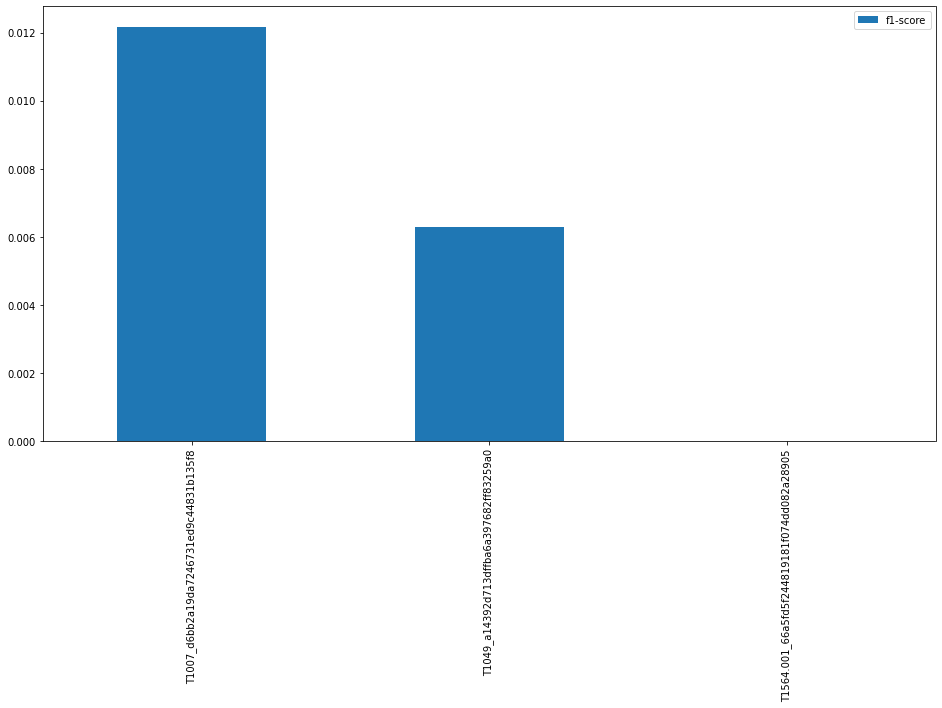

In [24]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()